# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.069532,False,-2.854355
1,0.191329,False,2.139069
2,-0.298564,False,-1.470854
3,-1.257976,True,0.566073
4,-1.341582,True,-1.787226
...,...,...,...
995,-1.713366,True,1.417412
996,-1.192193,False,-2.689358
997,-0.826791,False,-1.532473
998,-0.601015,False,-1.795128


<AxesSubplot: xlabel='v0'>

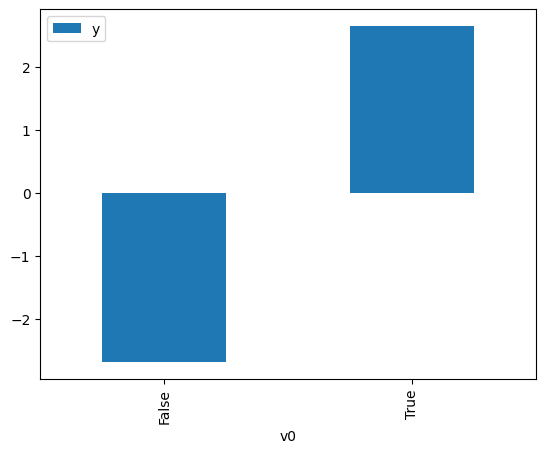

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

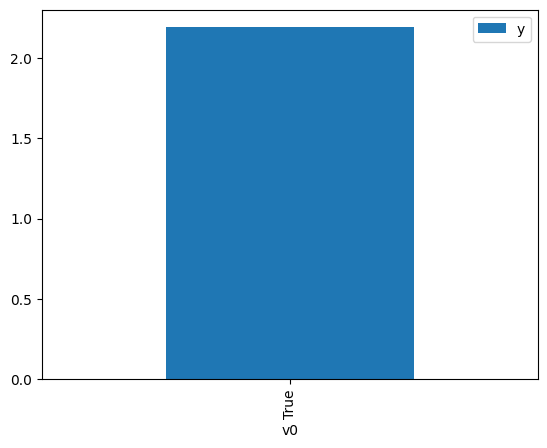

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.441920,False,-4.165511,0.593723,1.684288
1,0.526738,False,1.331623,0.515837,1.938597
2,-1.388270,False,-5.285540,0.591644,1.690207
3,0.719721,False,3.338032,0.508097,1.968127
4,-1.453592,False,-3.478530,0.594174,1.683008
...,...,...,...,...,...
995,1.655879,False,5.691550,0.470564,2.125108
996,0.191329,False,2.139069,0.529269,1.889400
997,0.587447,False,1.860334,0.513403,1.947788
998,-1.669463,False,-3.968736,0.602502,1.659746


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.516894,True,0.999046,0.403378,2.479066
1,-0.964484,True,1.091724,0.424888,2.353560
2,0.061491,True,5.154134,0.465542,2.148033
3,0.411311,True,4.004029,0.479537,2.085344
4,-1.832274,True,-0.151079,0.391256,2.555870
...,...,...,...,...,...
995,0.064569,True,4.643855,0.465665,2.147466
996,-0.964484,True,1.091724,0.424888,2.353560
997,-2.642618,True,-3.646408,0.360750,2.772003
998,0.254757,True,5.376866,0.473269,2.112964


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                              8600.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):                        0.00
Time:                        16:53:12   Log-Likelihood:                         -1392.3
No. Observations:                1000   AIC:                                      2789.
Df Residuals:                     998   BIC:                                      2798.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9118      0.025    118.623      0.000       2.864       2.960
x2             5.0526      0.051     98.354      0.000       4.952       5.153
==============================================================================
Omnibus:                        9.062   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               10.009
Skew:                          -0.164   Prob(JB):                      0.00671
Kurtosis:                       3.364   Cond. No.                         2.38
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""